This notebook contains code for plots used in presentations etc. Since we often have to revise these without wanting to run the entire original analysis, I copy data here from other notebooks. This makes reproducibility harder, maybe I will come up with a better way.

### Model performance comparison

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from textwrap import wrap

models = ["Last obs.", "Pixel average", "RF", "GAM", "Conv. LSTM"]
labels = np.array(["\n".join(wrap(m, 8)) for m in models])

smooth_r2   = np.array([0.48, 0.62, 0.49, 0.15, 0.41])
smooth_rmse = np.array([0.46, 0.38, 0.54, 1.11, 0.46])

raw_r2   = np.array([0.14, 0.17, 0.07, 0.15, 0.11])
raw_rmse = np.array([1.00, 0.83, 1.08, 1.09, 0.91])

# sort by decreasing rmse
sort_arg = np.argsort(smooth_rmse)[::-1]

labels_sort = labels[sort_arg]
smooth_r2_sort = smooth_r2[sort_arg]
smooth_rmse_sort = smooth_rmse[sort_arg]

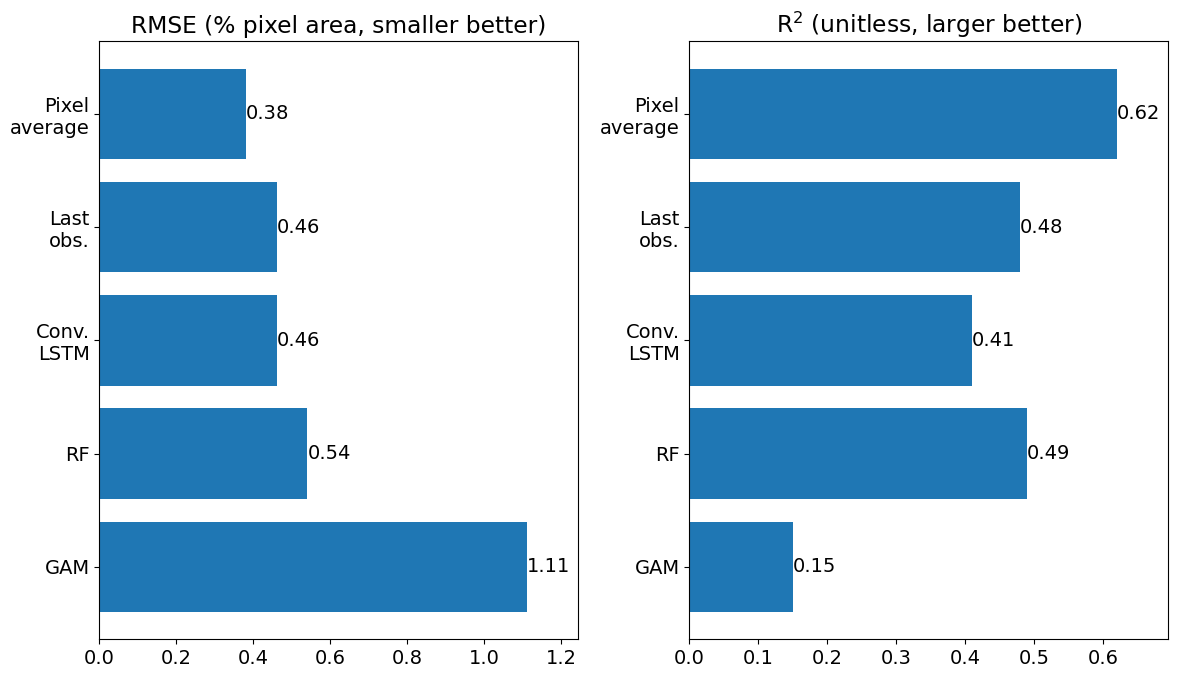

In [4]:
# Only show the results on smoothed models
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
x = np.arange(len(labels))

with plt.rc_context({"font.size": 14}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    
    b = ax2.barh(labels_sort, smooth_r2_sort, label="Smoothed")
    ax2.set_yticks(x, labels_sort)
    ax2.set_title("R$^2$ (unitless, larger better)")
    ax2.bar_label(b, fmt="%.2f")
    ax2.margins(x=0.12)
    
    b = ax1.barh(labels_sort, smooth_rmse_sort, label="Smoothed")
    ax1.set_yticks(x, labels_sort)
    ax1.set_title("RMSE (% pixel area, smaller better)")
    ax1.bar_label(b, fmt="%.2f")
    ax1.margins(x=0.12)
    
    plt.tight_layout()

plt.show()

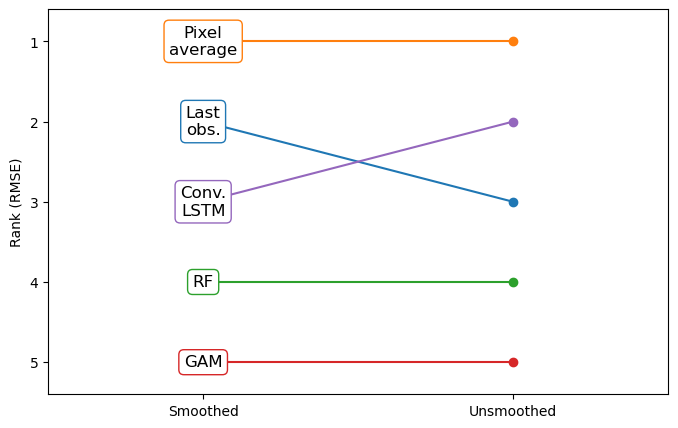

In [3]:
# Show the performance ranking by RMSE of the smoothed vs. unsmoothed models
# Yes, you have to run it twice
# https://yetanothermathprogrammingconsultant.blogspot.com/2022/05/ranking-using-numpyargsort.html

fig, ax = plt.subplots(figsize=(8, 5))
smooth_rank = np.argsort(np.argsort(smooth_rmse))+1
raw_rank    = np.argsort(np.argsort(raw_rmse))+1

for (label, s_rank, r_rank) in zip(labels, smooth_rank, raw_rank):
    p = plt.plot([1, 2], [s_rank, r_rank])
    plt.scatter([1, 2], [s_rank, r_rank])
    plt.text(
        1, s_rank, label, 
        ha="center", va="center", fontsize="large",
        bbox=dict(facecolor='white', edgecolor=p[-1].get_color(), boxstyle='round')
    )

#plt.scatter(np.ones(smooth_rank.shape), smooth_rank)
#plt.scatter(np.ones(raw_rank.shape)+1, raw_rank)
plt.gca().margins(y=0.1, x=0.5)
plt.gca().invert_yaxis()
plt.ylabel("Rank (RMSE)")
plt.xticks([1, 2], ["Smoothed", "Unsmoothed"])
#plt.gca().margins(x=0.1)
#plt.legend()
plt.show()

### Smoothing

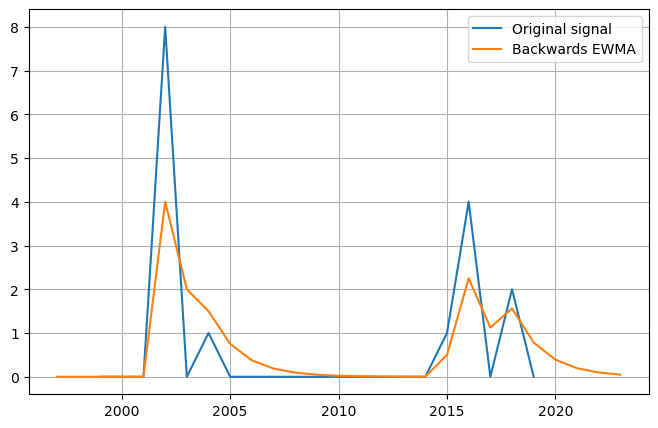

In [4]:
ts_smooth = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 2.00000000e+00, 1.50000000e+00,
       7.50000000e-01, 3.75000000e-01, 1.87500000e-01, 9.37500000e-02,
       4.68750000e-02, 2.34375000e-02, 1.17187500e-02, 5.85937500e-03,
       2.92968750e-03, 1.46484375e-03, 5.00732422e-01, 2.25036621e+00,
       1.12518311e+00, 1.56259155e+00, 7.81295776e-01, 3.90647888e-01,
       1.95323944e-01, 9.76619720e-02, 4.88309860e-02])

ts_raw = np.array([np.nan, np.nan,  0.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  4.,  0.,  2.,  0., np.nan, np.nan, np.nan,
       np.nan])

year = np.array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023])


fig, ax = plt.subplots(figsize=(8,5))
plt.plot(year, ts_raw, label="Original signal")
plt.plot(year, ts_smooth, label="Backwards EWMA")
plt.grid()
plt.legend()
plt.show()

### Damage area by agent

In [5]:
import geopandas as gpd
import pandas as pd
import os
from matplotlib import pyplot as plt
if 'notebooks' in os.getcwd():
    os.chdir("..")

In [6]:
damage = gpd.read_file("data_working/damage_merged.gdb/", layer="merged")
damage.head()

,SURVEY_YEAR,DCA_CODE,DAMAGE_TYPE_CODE,PERCENT_MID,SEVERITY,geometry
0,1998,11009,2,NaN,10,"MULTIPOLYGON (((-11882144.977 4313478.456, -11..."
1,1998,11001,2,NaN,10,"MULTIPOLYGON (((-11773618.818 3943088.479, -11..."
2,1998,11009,2,NaN,10,"MULTIPOLYGON (((-11871531.563 4292047.464, -11..."
3,1998,11050,2,NaN,10,"MULTIPOLYGON (((-11999290.62 3882834.371, -119..."
4,1998,11009,2,NaN,10,"MULTIPOLYGON (((-11777854.405 4285723.804, -11..."


In [7]:
damage["area"] = damage.geometry.area
damage["area_sqkm"] = damage["area"] * 1e-6

In [8]:
top_dca = damage.groupby("DCA_CODE").agg({"area_sqkm": "sum"}).reset_index().sort_values(by="area_sqkm", ascending=False)["DCA_CODE"][:4]
print(top_dca)

23    11050
6     11006
2     11002
11    11019
Name: DCA_CODE, dtype: int32


In [9]:
remap_dict = {
    11050: "Fir engraver",
    11006: "Mountain pine beetle",
    11002: "Western pine beetle",
    11019: "Pinyon ips",
}

In [10]:
damage_by_dca_year = damage.groupby(["SURVEY_YEAR", "DCA_CODE"]).agg({"area_sqkm": "sum"}).reset_index()
damage_by_dca_year = damage_by_dca_year[damage_by_dca_year.DCA_CODE.isin(top_dca)]
damage_by_dca_year = damage_by_dca_year.replace({"DCA_CODE": remap_dict})
damage_by_dca_year

,SURVEY_YEAR,DCA_CODE,area_sqkm
1,1997,Western pine beetle,201.065154
3,1997,Mountain pine beetle,1671.788761
7,1997,Pinyon ips,105.864210
13,1997,Fir engraver,424.098585
16,1998,Western pine beetle,203.311520
...,...,...,...
452,2022,Fir engraver,23764.552842
459,2023,Western pine beetle,7010.343999
461,2023,Mountain pine beetle,3739.786633
465,2023,Pinyon ips,116.502191


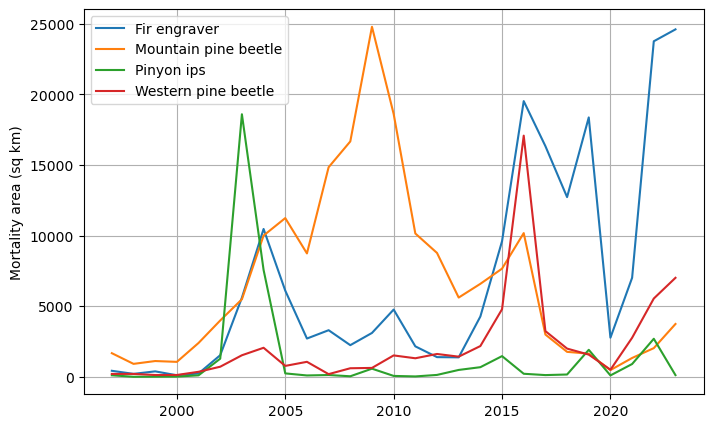

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

for key, data in damage_by_dca_year.groupby("DCA_CODE"):
    data.plot(x="SURVEY_YEAR", y="area_sqkm", label=key, ax=ax)

plt.ylabel("Mortality area (sq km)")
plt.xlabel("")
plt.grid()
plt.show()